### Importing

In [91]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, auc, roc_curve,confusion_matrix

import os

import sys

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input, Flatten, Conv1D, MaxPooling1D, Concatenate, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

from scipy.signal import find_peaks, peak_widths
from scipy.interpolate import interp1d

import neptune

In [2]:
import tensorflow
tensorflow.random.set_seed(42)

In [3]:
sys.path.insert(0,"/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester")

In [4]:
parquet_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data/parquet_files/"
models_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Models/"

In [5]:
# Data Class
import DataClass 
from DataClass import Data
# read prepared data
data = Data( 0, "", "",parquet_path)

In [90]:
! pip install -U neptune

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.1/448.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.4 MB/s eta 0:00:00


### Get the stances points data

In [6]:
stances=pd.read_parquet(parquet_path+'scaled_stances_statics_forHM.gzip')

In [7]:
stances.head()

,stance_index,stances_points
0,1,"[[0.04572564612326043, 0.02841677943166442, 0...."
1,2,"[[0.02969178634823301, 0.06815277580576458, 0...."
2,3,"[[0.029067930489731438, 0.03218390804597701, 0..."
3,4,"[[0.028962694789863058, 0.031111111111111117, ..."
4,5,"[[0.03057494184114323, 0.032585696148963186, 0..."


In [12]:
(stances).shape

(18226, 2)

In [35]:
sequences = np.array(stances['stances_points'].to_list())

In [67]:
from tqdm import tqdm
result=np.empty(shape=[len(sequences), 100,18])
for i,x in enumerate(tqdm(sequences)):
  temp = np.empty(shape=[100, 18])
  for j,y in enumerate(x):
    temp [j]= np.array(y, dtype=float)
    #print(temp.shape)
  result[i]=np.array(temp, dtype=float)

100%|██████████| 18226/18226 [00:03<00:00, 4802.31it/s]


saving the array


```
with open(parquet_path+'stances_points.npy', 'wb') as f:
    np.save(f, result)


```

reading the file
```
with open(parquet_path+'stances_points.npy', 'rb') as f:

    r = np.load(f)
```




In [88]:
result.shape

(18226, 100, 18)

### Get the features

In [ ]:
scaled_stances_statics_df=pd.read_parquet(parquet_path+'scaled_stances_statics.gzip')

In [ ]:
scaled_stances_statics_df.shape

(18226, 177)

In [78]:
col_to_keep=['l_strides_time',
'l_swings_time',
'l_stances_time',
'l_peaks_heel',
'l_peaks_toe',
'r_strides_time',
'r_swings_time',
'r_stances_time',
'r_peaks_heel',
'r_peaks_toe',
'l_max_peak',
'r_max_peak']

for col in ["l_total","r_total","L1",	"L2",	"L3"	,"L4"	,"L5",	"L6",	"L7"	,"L8",	"R1",	"R2"	,"R3",	"R4",	"R5",	"R6",	"R7",	"R8"]:
  col_to_keep.append(col+"_fwhm")

In [79]:
features = scaled_stances_statics_df[col_to_keep]

In [80]:
features.shape

(18226, 30)

### Get the y

In [86]:
y = scaled_stances_statics_df['y']

In [87]:
y.shape

(18226,)

In [84]:
level = scaled_stances_statics_df['level']

In [85]:
level.shape

(18226,)

In [89]:
level[0]

3.0

### The model

In [92]:
from getpass import getpass


my_api_token = getpass("Enter your Neptune API token: ")
my_project="nemat-aloush/MultidimTimeSeries"
run = neptune.init_run(api_token=my_api_token, project=my_project)

Enter your Neptune API token: ··········


In [98]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv1D, MaxPooling1D, concatenate
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [99]:
# Split the data into training and testing sets
X_train1, X_test1, X_train2, X_test2, y_train, y_test = train_test_split(features, result, y, test_size=0.2, random_state=42)

# Define the input layers for the two datasets
input1 = Input(shape=(features.shape[1],))
input2 = Input(shape=(result.shape[1], result.shape[2]))

# Define the dense layers for the first dataset
dense1 = Dense(64, activation='relu')(input1)
dense2 = Dense(32, activation='relu')(dense1)

# Define the convolutional layers for the second dataset
conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(input2)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)
flatten = Flatten()(pool2)

# Concatenate the outputs of the two datasets
concat = concatenate([dense2, flatten])

# Define the output layer for binary classification
output = Dense(1, activation='sigmoid')(concat)

# Define the model with two inputs and one output
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Use early stopping to prevent overfitting during training
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model with both datasets
history = model.fit([X_train1, X_train2], y_train, validation_split=0.2, epochs=10, batch_size=32, callbacks=[early_stopping])


Epoch 1/10
365/365 [==============================] - 7s 15ms/step - loss: 1.4135 - accuracy: 0.7323 - val_loss: 0.4441 - val_accuracy: 0.8062
Epoch 2/10
365/365 [==============================] - 5s 14ms/step - loss: 0.3687 - accuracy: 0.8503 - val_loss: 0.3387 - val_accuracy: 0.8752
Epoch 3/10
365/365 [==============================] - 4s 11ms/step - loss: 0.3005 - accuracy: 0.8892 - val_loss: 0.2738 - val_accuracy: 0.9026
Epoch 4/10
365/365 [==============================] - 4s 12ms/step - loss: 0.2529 - accuracy: 0.9103 - val_loss: 0.2272 - val_accuracy: 0.9266
Epoch 5/10
365/365 [==============================] - 6s 16ms/step - loss: 0.2109 - accuracy: 0.9287 - val_loss: 0.2426 - val_accuracy: 0.9198
Epoch 6/10
365/365 [==============================] - 4s 11ms/step - loss: 0.1792 - accuracy: 0.9413 - val_loss: 0.1883 - val_accuracy: 0.9455
Epoch 7/10
365/365 [==============================] - 4s 12ms/step - loss: 0.1605 - accuracy: 0.9487 - val_loss: 0.2013 - val_accuracy: 0.9290

In [100]:
# Evaluate the model on the test set
score = model.evaluate([X_test1, X_test2], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.15342304110527039
Test accuracy: 0.9558420181274414


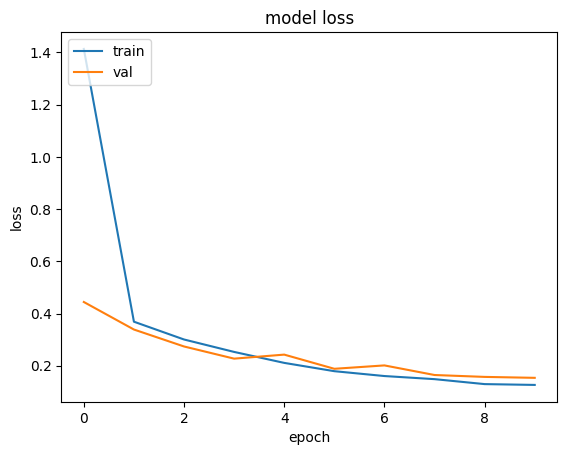

In [101]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

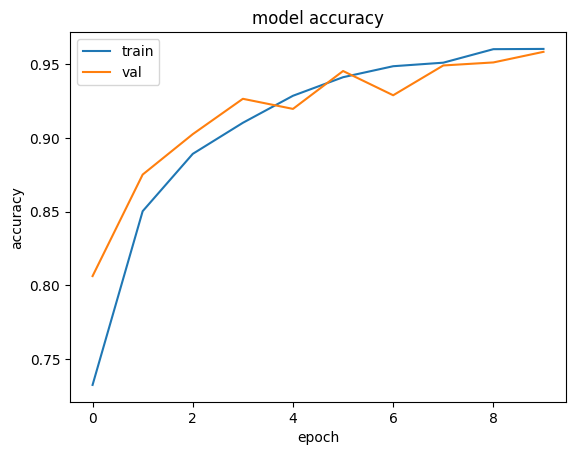

In [102]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

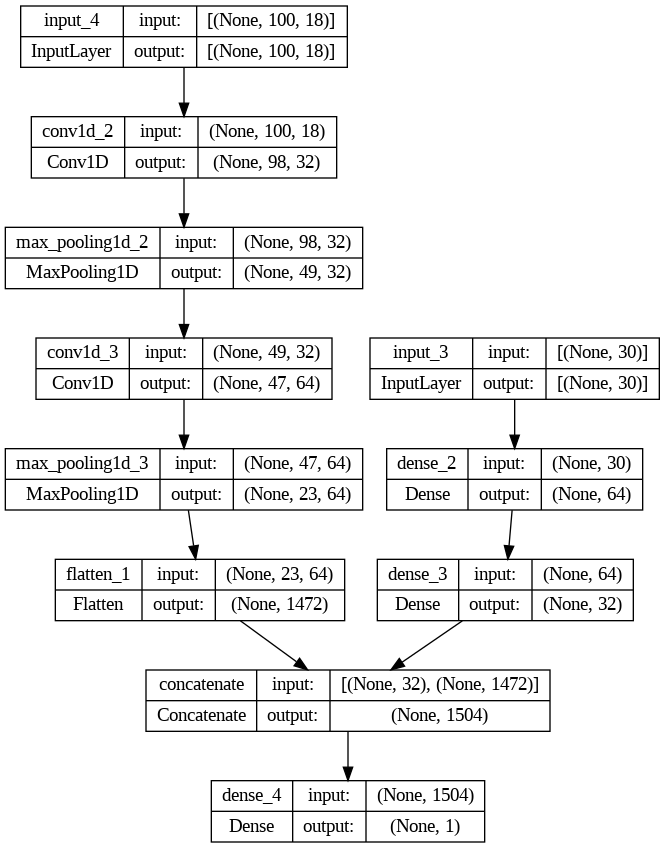

In [103]:
plot_model(model, to_file="/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Models/hybrid_model_all_data_1.png", show_shapes=True,show_layer_names=True)

In [104]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100, 18)]    0           []                               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 98, 32)       1760        ['input_4[0][0]']                
                                                                                                  
 max_pooling1d_2 (MaxPooling1D)  (None, 49, 32)      0           ['conv1d_2[0][0]']               
                                                                                                  
 input_3 (InputLayer)           [(None, 30)]         0           []                               
                                                                                              

## Model 2

In [130]:
# Split the data into training and testing sets
X_train1, X_test1, X_train2, X_test2, y_train, y_test = train_test_split(features, result, y, test_size=0.2, random_state=42)

# Define the input layers for the two datasets
input1 = Input(shape=(features.shape[1],))
input2 = Input(shape=(result.shape[1], result.shape[2]))

# Define the dense layers for the first dataset
dense1 = Dense(64, activation='relu')(input1)
dense2 = Dense(32, activation='relu')(dense1)

# Define the convolutional layers for the second dataset
conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(input2)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)
flatten = Flatten()(pool2)

# Concatenate the outputs of the two datasets
concat = concatenate([dense2, flatten])

# Define the output layer for binary classification
output = Dense(1, activation='sigmoid')(concat)

# Define the model with two inputs and one output
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Use early stopping to prevent overfitting during training
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model with both datasets
history = model.fit([X_train1, X_train2], y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping])


Epoch 1/50
365/365 [==============================] - 8s 17ms/step - loss: 0.5607 - accuracy: 0.7816 - val_loss: 0.3677 - val_accuracy: 0.8570
Epoch 2/50
365/365 [==============================] - 5s 13ms/step - loss: 0.3460 - accuracy: 0.8692 - val_loss: 0.2770 - val_accuracy: 0.9053
Epoch 3/50
365/365 [==============================] - 7s 20ms/step - loss: 0.2855 - accuracy: 0.8949 - val_loss: 0.2537 - val_accuracy: 0.9184
Epoch 4/50
365/365 [==============================] - 5s 14ms/step - loss: 0.2353 - accuracy: 0.9190 - val_loss: 0.2628 - val_accuracy: 0.9057
Epoch 5/50
365/365 [==============================] - 5s 14ms/step - loss: 0.2073 - accuracy: 0.9304 - val_loss: 0.2230 - val_accuracy: 0.9290
Epoch 6/50
365/365 [==============================] - 7s 19ms/step - loss: 0.1732 - accuracy: 0.9455 - val_loss: 0.2030 - val_accuracy: 0.9321
Epoch 7/50
365/365 [==============================] - 5s 13ms/step - loss: 0.1571 - accuracy: 0.9493 - val_loss: 0.1665 - val_accuracy: 0.9482

In [131]:
# Evaluate the model on the test set
score = model.evaluate([X_test1, X_test2], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.16378937661647797
Test accuracy: 0.9566648602485657


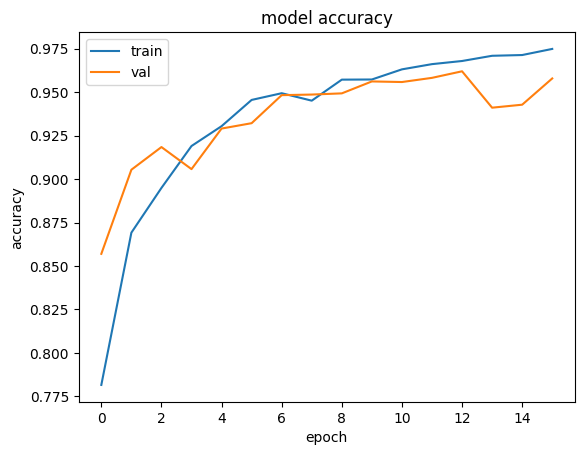

In [132]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

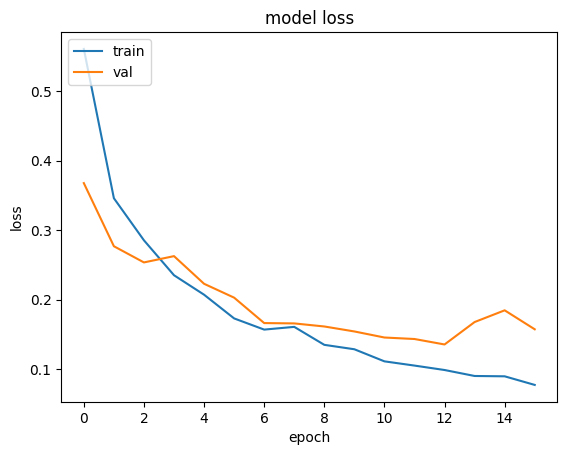

In [133]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### with cross validation

In [110]:
features=np.array(features)

In [124]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv1D, MaxPooling1D, concatenate
from sklearn.model_selection import StratifiedKFold

# Define the input layers for the two datasets
input1 = Input(shape=(features.shape[1],))
input2 = Input(shape=(result.shape[1], result.shape[2]))

# Define the dense layers for the first dataset
dense1 = Dense(64, activation='relu')(input1)
dense2 = Dense(32, activation='relu')(dense1)

# Define the convolutional layers for the second dataset
conv1 = Conv1D(filters=32, kernel_size=5, activation='relu')(input2)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)
flatten = Flatten()(pool2)

# Concatenate the outputs of the two datasets
concat = concatenate([dense2, flatten])

# Define the output layer for binary classification
output = Dense(1, activation='sigmoid')(concat)

# Define the model with two inputs and one output
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Define the stratified K-fold cross-validation iterator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train and evaluate the model with cross-validation
val_accs = []
model_history=[]
for train_index, test_index in skf.split(features, y):
    X_train1, X_test1 = features[train_index], features[test_index]
    X_train2, X_test2 = result[train_index], result[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model with both datasets
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    model_history.append(model.fit([X_train1, X_train2], y_train,validation_split=0.2, epochs=20, batch_size=32,callbacks=[early_stopping]))

    # Evaluate the model on the test set
    score = model.evaluate([X_test1, X_test2], y_test)
    val_accs.append(score[1])

# Print the average validation accuracy across all folds
print("Mean validation accuracy:", np.mean(val_accs))

Epoch 1/20
365/365 [==============================] - 13s 26ms/step - loss: 0.6128 - accuracy: 0.7837 - val_loss: 0.1720 - val_accuracy: 0.9410
Epoch 2/20
365/365 [==============================] - 10s 28ms/step - loss: 0.3202 - accuracy: 0.8744 - val_loss: 0.3838 - val_accuracy: 0.8525
Epoch 3/20
365/365 [==============================] - 8s 22ms/step - loss: 0.2457 - accuracy: 0.9161 - val_loss: 1.1264 - val_accuracy: 0.5761
Epoch 4/20
365/365 [==============================] - 9s 26ms/step - loss: 0.2026 - accuracy: 0.9310 - val_loss: 1.1156 - val_accuracy: 0.5648
Epoch 5/20
365/365 [==============================] - 7s 19ms/step - loss: 0.1647 - accuracy: 0.9477 - val_loss: 1.1732 - val_accuracy: 0.5727
Epoch 6/20
114/114 [==============================] - 1s 11ms/step - loss: 0.2495 - accuracy: 0.9166
Epoch 1/20
365/365 [==============================] - 7s 19ms/step - loss: 0.1270 - accuracy: 0.9595 - val_loss: 0.5870 - val_accuracy: 0.7833
Epoch 2/20
365/365 [===================

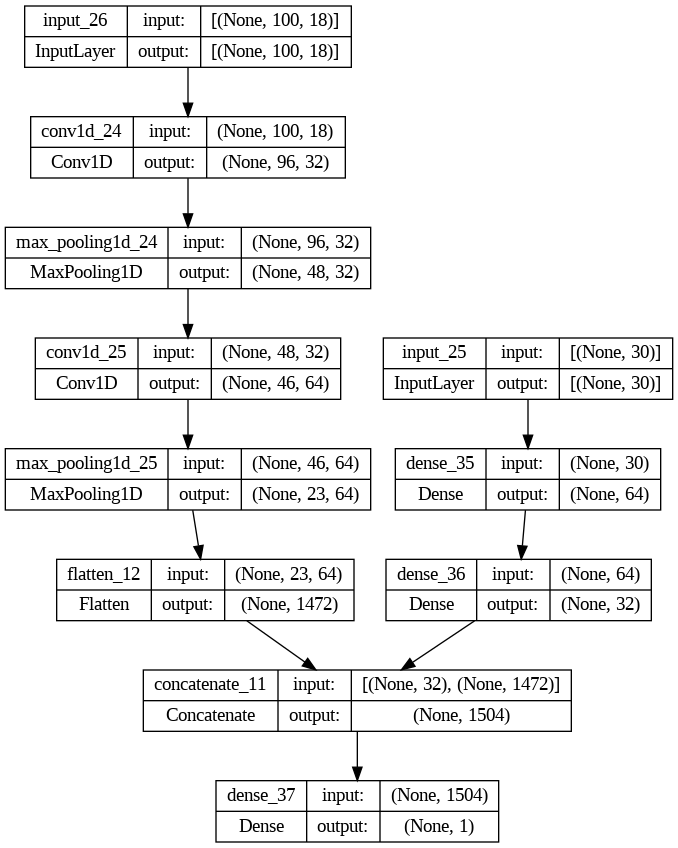

In [128]:
plot_model(model, to_file="/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Models/hybrid_model_cv_all_data_1.png", show_shapes=True,show_layer_names=True)

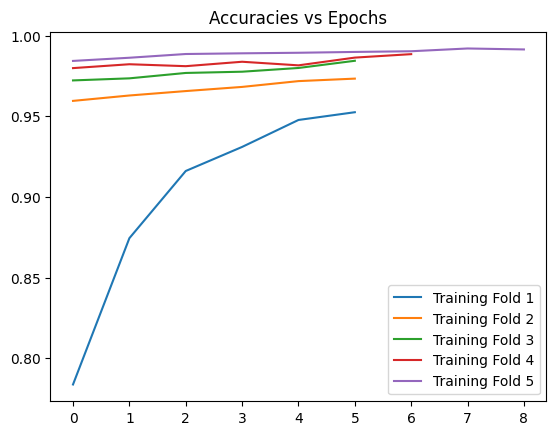

In [127]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['accuracy'], label='Training Fold 3')
plt.plot(model_history[3].history['accuracy'], label='Training Fold 4')
plt.plot(model_history[4].history['accuracy'], label='Training Fold 5')
plt.legend()
plt.show()

### cross validation ?


In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np

# Model configuration
batch_size = 50
img_width, img_height, img_num_channels = 32, 32, 3
loss_function = sparse_categorical_crossentropy
no_classes = 100
no_epochs = 25
optimizer = Adam()
verbosity = 1
num_folds = 10

# Load CIFAR-10 data
(input_train, target_train), (input_test, target_test) = cifar10.load_data()

# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Merge inputs and targets
inputs = np.concatenate((input_train, input_test), axis=0)
targets = np.concatenate((target_train, target_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  # Define the model architecture
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(no_classes, activation='softmax'))

  # Compile the model
  model.compile(loss=loss_function,
                optimizer=optimizer,
                metrics=['accuracy'])


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(inputs[train], targets[train],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity)

  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

### Model (Severity Detection)

In [134]:
level.replace(2, 1, inplace= True) 
level.replace(3, 2, inplace= True)  
level.replace(4, 3, inplace= True)  
level=level.astype('int')

In [135]:
from keras.utils import to_categorical
y_onehot = to_categorical(level, num_classes=4)

In [136]:
# Split the data into training and testing sets
X_train1, X_test1, X_train2, X_test2, y_train, y_test = train_test_split(features, result, y_onehot, test_size=0.2, random_state=42)

# Define the input layers for the two datasets
input1 = Input(shape=(features.shape[1],))
input2 = Input(shape=(result.shape[1], result.shape[2]))

# Define the dense layers for the first dataset
dense1 = Dense(64, activation='relu')(input1)
dense2 = Dense(32, activation='relu')(dense1)

# Define the convolutional layers for the second dataset
conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(input2)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)
flatten = Flatten()(pool2)

# Concatenate the outputs of the two datasets
concat = concatenate([dense2, flatten])

# Define the output layer for binary classification
output = Dense(4, activation='softmax')(concat)

# Define the model with two inputs and one output
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Use early stopping to prevent overfitting during training
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model with both datasets
history = model.fit([X_train1, X_train2], y_train, validation_split=0.2, epochs=10, batch_size=32, callbacks=[early_stopping])


Epoch 1/10
365/365 [==============================] - 6s 13ms/step - loss: 0.4033 - accuracy: 0.6115 - val_loss: 0.3145 - val_accuracy: 0.7287
Epoch 2/10
365/365 [==============================] - 6s 17ms/step - loss: 0.2912 - accuracy: 0.7569 - val_loss: 0.2471 - val_accuracy: 0.8189
Epoch 3/10
365/365 [==============================] - 4s 11ms/step - loss: 0.2353 - accuracy: 0.8236 - val_loss: 0.2178 - val_accuracy: 0.8429
Epoch 4/10
365/365 [==============================] - 4s 11ms/step - loss: 0.1967 - accuracy: 0.8601 - val_loss: 0.1795 - val_accuracy: 0.8844
Epoch 5/10
365/365 [==============================] - 6s 17ms/step - loss: 0.1721 - accuracy: 0.8840 - val_loss: 0.1756 - val_accuracy: 0.8875
Epoch 6/10
365/365 [==============================] - 4s 11ms/step - loss: 0.1575 - accuracy: 0.8944 - val_loss: 0.1499 - val_accuracy: 0.9053
Epoch 7/10
365/365 [==============================] - 4s 11ms/step - loss: 0.1410 - accuracy: 0.9082 - val_loss: 0.1596 - val_accuracy: 0.8957

In [137]:
# Evaluate the model on the test set
score = model.evaluate([X_test1, X_test2], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12921947240829468
Test accuracy: 0.9226549863815308


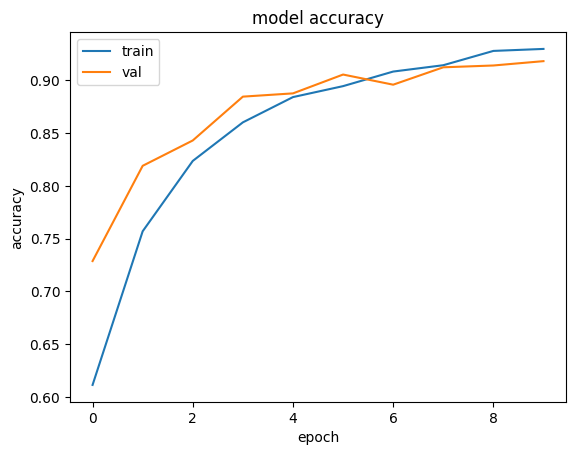

In [138]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

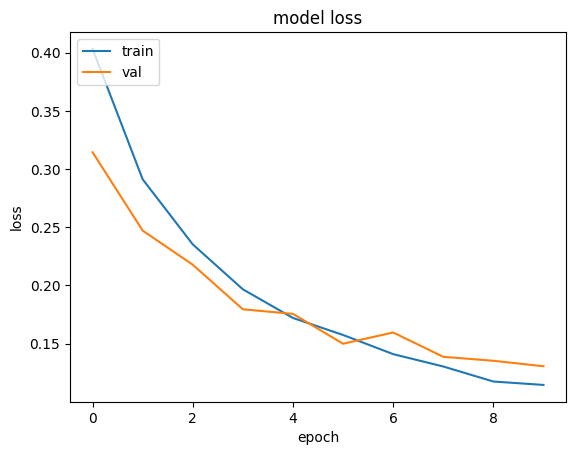

In [139]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

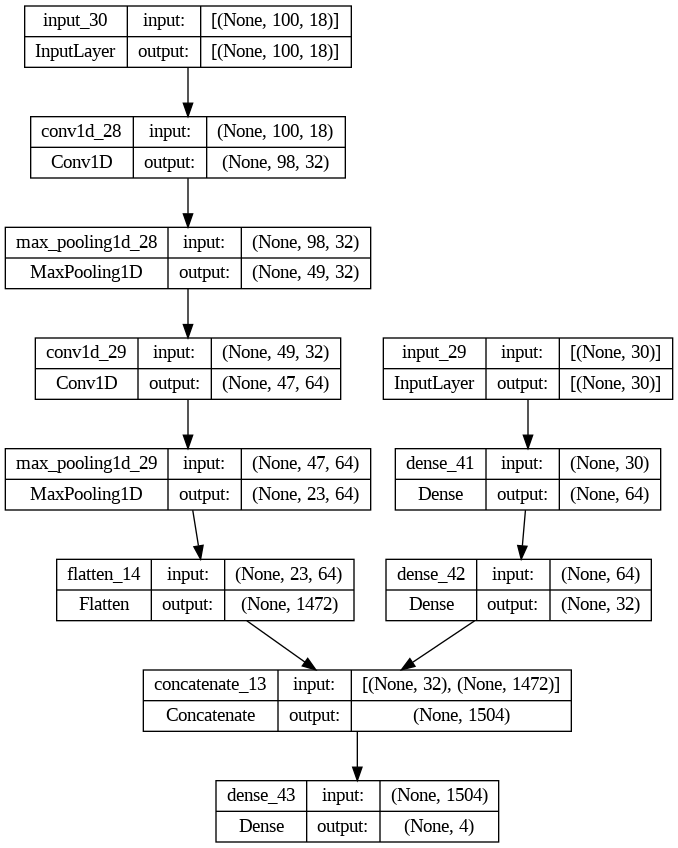

In [140]:
plot_model(model, to_file="/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Models/hybrid_model_all_data_multi_1.png", show_shapes=True,show_layer_names=True)